In [5]:
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import product
from mplsoccer import Pitch

In [3]:
countries = ['England', 'France', 'Germany', 'Italy', 'Spain']

matches = pd.DataFrame()

for country in countries:
     df = pd.read_csv(f"../00_data/01_actions_data/matches_{country}.csv")
     matches = pd.concat([matches, df])

matches['date'] = pd.to_datetime(matches['dateutc'], format='%Y-%m-%d %H:%M:%S')
matches['date'] = matches['date'].dt.date
matches['label'] = matches['label'].apply(lambda x: x.encode('utf-8').decode('unicode-escape'))

matches['home_team'] = matches['label'].str.split(',').str[0].str.split(' - ').str[0]
matches['away_team'] = matches['label'].str.split(',').str[0].str.split(' - ').str[1]

matches['home_goals'] = matches['label'].str.split(',').str[1].str.split(' - ').str[0].astype(int)
matches['away_goals'] = matches['label'].str.split(',').str[1].str.split(' - ').str[1].astype(int)

matches = matches[['date', 'wyId', 'home_team', 'team1.teamId', 'away_team', 'team2.teamId', 'home_goals', 'away_goals']]

matches = matches.rename(columns={'wyId': 'game_id', 'team1.teamId': 'home_team_id', 'team2.teamId': 'away_team_id'})

matches['result'] = np.where(matches['home_goals'] > matches['away_goals'], 'H', np.where(matches['home_goals'] < matches['away_goals'], 'A', 'D'))

matches = matches.sort_values('date')
matches = matches.reset_index(drop=True)

matches.to_csv('../00_data/01_actions_data/matches.csv', index=False)

matches

,date,game_id,home_team,home_team_id,away_team,away_team_id,home_goals,away_goals,result
0,2017-08-04,2500691,Monaco,3780,Toulouse,19830,3,2,H
1,2017-08-05,2500694,Saint-Étienne,3775,Nice,3782,1,0,H
2,2017-08-05,2500688,Olympique Lyonnais,3766,Strasbourg,3779,4,0,H
3,2017-08-05,2500690,Metz,3777,Guingamp,3785,1,3,A
4,2017-08-05,2500693,PSG,3767,Amiens SC,3789,2,0,H
...,...,...,...,...,...,...,...,...,...
1821,2018-05-20,2576331,Udinese,3166,Bologna,3163,1,0,H
1822,2018-05-20,2576332,Napoli,3197,Crotone,3187,2,1,H
1823,2018-05-20,2576333,Milan,3157,Fiorentina,3176,5,1,H
1824,2018-05-20,2565922,Barcelona,676,Real Sociedad,687,1,0,H


## Binning

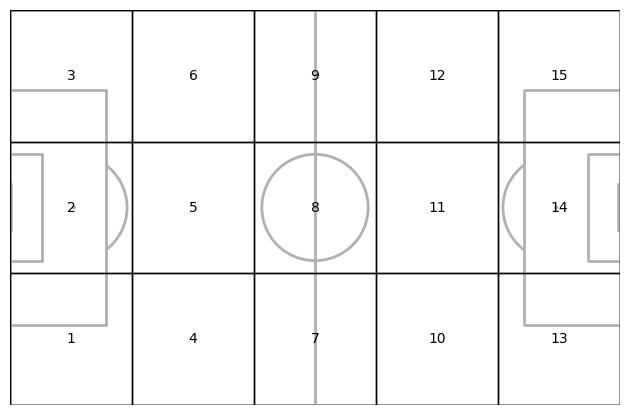

In [6]:
bin_dims = (5, 3)

y_bins = np.linspace(0, 68, bin_dims[1] + 1)  
y_df = pd.DataFrame({"y_bin_start": y_bins[:-1], "y_bin_end": y_bins[1:]})

x_bins = np.linspace(0, 105, bin_dims[0] + 1)
x_df = pd.DataFrame({"x_bin_start": x_bins[:-1], "x_bin_end": x_bins[1:]})

segments_df = pd.DataFrame(
    list(product(
        zip(x_df["x_bin_start"], x_df["x_bin_end"]),
        zip(y_df["y_bin_start"], y_df["y_bin_end"])
    )),
    columns=["x_bins", "y_bins"]
)
segments_df["x_bin_start"], segments_df["x_bin_end"] = zip(*segments_df["x_bins"])
segments_df["y_bin_start"], segments_df["y_bin_end"] = zip(*segments_df["y_bins"])
segments_df = segments_df.drop(columns=["x_bins", "y_bins"])
segments_df['segment'] = segments_df.index + 1

pitch = Pitch(pitch_type='uefa')

fig, ax = pitch.draw()

for i, row in segments_df.iterrows():
    x = (row["x_bin_start"] + row["x_bin_end"]) / 2
    y = (row["y_bin_start"] + row["y_bin_end"]) / 2
    ax.add_patch(plt.Rectangle((row["x_bin_start"], row["y_bin_start"]), row["x_bin_end"] - row["x_bin_start"], row["y_bin_end"] - row["y_bin_start"], fill=None))
    ax.text(x, y, int(row['segment']), ha='center', va='center')
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 68)
    ax.axis('off')

plt.show()

In [8]:
actions = pd.read_csv('../00_data/01_actions_data/actions.csv', index_col=0)

actions = actions[
     ['game_id', 'team_id', 'period_id', 'time_seconds', 'start_x', 'start_y', 'end_x', 'end_y', 'type_name', 'result_name']
]

actions = actions[actions['game_id'].isin(matches['game_id'])]

actions

,game_id,team_id,period_id,time_seconds,start_x,start_y,end_x,end_y,type_name,result_name
0,2500089,1659,1,2.763597,52.50,34.00,63.00,30.60,pass,success
1,2500089,1659,1,4.761353,63.00,30.60,64.05,10.20,pass,success
2,2500089,1659,1,5.533097,64.05,10.20,72.45,20.40,pass,success
3,2500089,1659,1,7.707561,72.45,20.40,35.70,19.04,pass,success
4,2500089,1659,1,11.614943,35.70,19.04,30.45,12.24,pass,success
...,...,...,...,...,...,...,...,...,...,...
2319206,2565557,696,2,2836.932876,8.40,60.52,26.25,36.72,dribble,success
2319207,2565557,696,2,2839.889917,26.25,36.72,11.55,65.28,pass,success
2319208,2565557,696,2,2845.944625,11.55,65.28,8.40,62.56,take_on,fail
2319209,2565557,696,2,2849.922762,7.35,63.24,7.35,63.24,foul,success


In [11]:
def map_to_segment(x, y, period, mirror_period=False):
    if mirror_period is True:
        if period == '2':
            x = 105 - x
            y = 68 - y
        else:
            x = x
            y = x

    for i, row in segments_df.iterrows():
        if row['x_bin_start'] <= x <= row['x_bin_end'] and row['y_bin_start'] <= y <= row['y_bin_end']:
            return row['segment']
        

mirror_sec_period = False

for i, row in tqdm(actions.iterrows(), total=actions.shape[0]):
    actions.loc[i, 'start_segment'] = map_to_segment(row['start_x'], row['start_y'], row['period_id'], mirror_sec_period)
    actions.loc[i, 'end_segment'] = map_to_segment(row['end_x'], row['end_y'], row['period_id'], mirror_sec_period)

actions

100%|██████████| 2319211/2319211 [12:55<00:00, 2989.94it/s]


,game_id,team_id,period_id,time_seconds,start_x,start_y,end_x,end_y,type_name,result_name,start_segment,end_segment
0,2500089,1659,1,2.763597,52.50,34.00,63.00,30.60,pass,success,8.0,8.0
1,2500089,1659,1,4.761353,63.00,30.60,64.05,10.20,pass,success,8.0,10.0
2,2500089,1659,1,5.533097,64.05,10.20,72.45,20.40,pass,success,10.0,10.0
3,2500089,1659,1,7.707561,72.45,20.40,35.70,19.04,pass,success,10.0,4.0
4,2500089,1659,1,11.614943,35.70,19.04,30.45,12.24,pass,success,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2319206,2565557,696,2,2836.932876,8.40,60.52,26.25,36.72,dribble,success,3.0,5.0
2319207,2565557,696,2,2839.889917,26.25,36.72,11.55,65.28,pass,success,5.0,3.0
2319208,2565557,696,2,2845.944625,11.55,65.28,8.40,62.56,take_on,fail,3.0,3.0
2319209,2565557,696,2,2849.922762,7.35,63.24,7.35,63.24,foul,success,3.0,3.0


In [12]:
actions.to_csv(f"../00_data/01_actions_data/actions_segmented_{bin_dims[0]}x{bin_dims[1]}.csv")